In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import numpy as np
import pandas as pd

feature = pd.read_csv('feature.csv', header=None)
feature.fillna(0, inplace=True)
label_csv = pd.read_csv('label_bianhao.csv', header=None)

In [ ]:
max_col = feature.abs().idxmax(axis = 1)
# feature_data = [feature.iloc[index : index+1, :].values[0][max_colum - 50: max_colum + 50] for index, max_colum in zip(feature.index, max_col)]
feature_data = [feature.iloc[0:1, :].values[0][index: index + 5] for index in range(1000)]

In [ ]:
# label_csv = pd.read_csv('label_bianhao.csv', header=None)
label_csv.drop(label_csv.columns[0], axis=1, inplace=True)
label_csv.fillna(0, inplace=True)
# label_data = [label_csv.iloc[index : index+1, :].values[0][max_colum - 50: max_colum + 50] for index, max_colum in zip(label_csv.index, max_col)]
# label_data = [label_data.iloc[0:1, :].values[0][index: index + 10] for index in range(100)]

In [ ]:
label_data = [label_csv.iloc[0:1, :].values[0][index + 4: index + 5] for index in range(1000)]
len(label_data)

1000

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset as tDataset

class DateDataNew(tDataset):
    def __init__(self):
        self.x,self.y = np.array(feature_data), np.array(label_data)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index],self.y[index], len(self.y[index])-1

In [ ]:
from torch.utils.data import DataLoader, random_split

dataset = DateDataNew()

# Assuming you have a dataset named 'dataset' and DataLoader parameters are defined
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the sizes for train and test sets
train_size = int(0.95 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

# Split the dataset into train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader instances for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from torch import nn
import torch
import numpy as np
from torch.nn import MSELoss
import pandas as pd
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import cross_entropy, softmax
import numpy as np
from torch.utils.data import Dataset as tDataset

class Seq2Seq(nn.Module):
    def __init__(self, units, max_pred_len, start_token, end_token):
        super().__init__()
        self.units = units
        # encoder
        self.encoder = nn.LSTM(1, units, 2, batch_first=True)

        # decoder
        # self.decoder_cell = nn.LSTMCell(1, units)
        self.decoder_dense = nn.Linear(units, 1)
        self.criterion = nn.MSELoss()
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.max_pred_len = max_pred_len
        self.start_token = start_token
        self.end_token = end_token

    def encode(self, x):
        hidden = (torch.zeros(2, x.shape[0], self.units).to(device, dtype=torch.float32), torch.zeros(2, x.shape[0], self.units).to(device, dtype=torch.float32))
        o, (h, c) = self.encoder(x.unsqueeze(-1), hidden)
        return h, c

    def inference(self, x):
        self.eval()
        hx, cx = self.encode(x)
        hx, cx = hx[0], cx[0]
        # start = torch.tensor(np.array([y])).to(device, dtype=torch.float32)
        # start = start.type(torch.float32)
        # dec_emb_in = start.unsqueeze(-1).unsqueeze(-1)
        # dec_emb_in = dec_emb_in.permute(1, 0, 2)
        # dec_in = dec_emb_in[0]
        output = []
        for i in range(self.max_pred_len):
            # hx, cx = self.decoder_cell(dec_in, (hx, cx))
            o = self.decoder_dense(hx)
            dec_in = o.unsqueeze(-1).permute(1, 0, 2)[0]
            output.append(o)
        output = torch.stack(output, dim=0)
        self.train()
        return output.permute(1, 0, 2).view(-1, self.max_pred_len)

    def train_logit(self, x, y):
        hx, cx = self.encode(x)
        hx, cx = hx[0], cx[0]
        # dec_in = y.unsqueeze(-1)
        # dec_emb_in = dec_in.permute(1, 0, 2)
        output = []
        # for i in range(dec_emb_in.shape[0]):
        # hx, cx = self.decoder_cell(dec_emb_in[i], (hx, cx))
        o = self.decoder_dense(hx)
        output.append(o)
        output = torch.stack(output, dim=0)
        return output.permute(1, 0, 2)

    def step(self, x, y):
        self.opt.zero_grad()
        batch_size = x.shape[0]
        logit = self.train_logit(x, y)
        dec_out = y
        loss = self.criterion(logit.reshape(-1, 1).reshape(-1), dec_out.reshape(-1))
        loss.backward()
        self.opt.step()
        return loss.detach()

# class DateDataNew(tDataset):
#     def __init__(self):
#         feature = pd.read_csv('feature.csv', header=None)
#         feature.fillna(0, inplace=True)
#         feature_new = feature.iloc[:, :100]
#         label = pd.read_csv('label_bianhao.csv', header=None)
#         label.drop(label.columns[0], axis=1, inplace=True)
#         label.fillna(0, inplace=True)
#         lable_test_data = label.iloc[:, :100]
#         self.x,self.y = np.array(feature_new.values), np.array(lable_test_data.values)

#     def __len__(self):
#         return len(self.x)

#     def __getitem__(self, index):
#         return self.x[index],self.y[index], len(self.y[index])-1


def train(loopsize):

    # loader = DataLoader(dataset,batch_size=32,shuffle=True)
    model = Seq2Seq(units=3, max_pred_len=1, start_token=0.00, end_token=0.000000000000000000000001).to(device)
    for i in range(loopsize):
        for batch_idx, batch in enumerate(train_loader):
            x, y, decoder_len = batch
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            loss = model.step(x, y)
            if batch_idx % 70 == 0:
                pred = model.inference(x[0:1])
                res = pred[0]
                src = x[0:1]
                print(
                    "Epoch: ", i,
                    "| t: ", batch_idx,
                    "| loss: %.20f" % loss,
                )
    torch.save(model.state_dict(), 'test_model.pth')
        # for batch_idx, batch in enumerate(test_loader):

In [ ]:
train(2000)

In [ ]:
model = Seq2Seq(units=3, max_pred_len=1, start_token=0.00, end_token=0.000000000000000000000001).to(device)

# Load the saved model state dictionary
model.load_state_dict(torch.load('test_model.pth'))
# Set the model to evaluation mode
model.eval()


Seq2Seq(
  (encoder): LSTM(1, 3, num_layers=2, batch_first=True)
  (decoder_dense): Linear(in_features=3, out_features=1, bias=True)
  (criterion): MSELoss()
)

In [ ]:
import matplotlib.pyplot as plt

first_feature = feature[0]
first_real_lable = label_csv.iloc[0:1, 1:]

# f1 = np.array(feature[0])
# predict = np.array([model.inference(torch.tensor(np.array([f1[i * 100: (i + 1) * 100]]), dtype = torch.float32)).detach().numpy()[0] for i in range(int(f1.size / 100 - 1))])
# predict = model.inference(torch.tensor(np.array([f1[497: 597]]), dtype = torch.float32)).detach().numpy()[0]

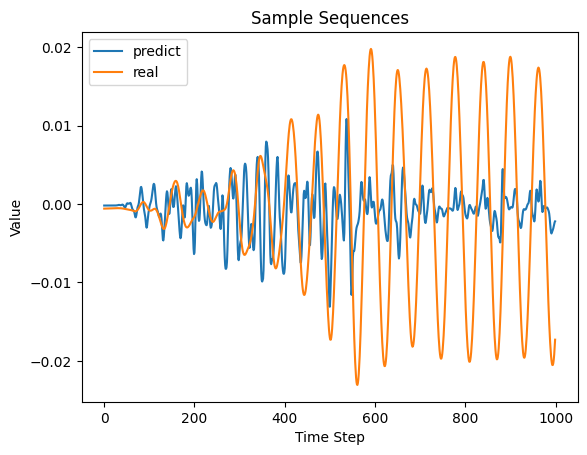

In [ ]:
predict = np.array([model.inference(torch.tensor(np.array([np.array(feature.iloc[0:1, :])[0][i: i+5]]), dtype = torch.float32)).detach().numpy()[0] for i in range(int(1000))])
plt.plot(np.concatenate((predict)), label='predict')
plt.plot(first_real_lable.values[0][:1000], label='real')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Sample Sequences')
plt.legend()
plt.show()